In [1]:
!pip install sensormotion

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sensormotion: filename=sensormotion-1.1.4-py3-none-any.whl size=19658 sha256=645134a09893986ee334ba92ce0686920beb70924e9ac315c754afc37b536501
  Stored in directory: /root/.cache/pip/wheels/a2/a1/d6/d7229aff17b9a309282d830747f636814a3523178f171c7ffd
Successfully built sensormotion


In [2]:
"""
Peak detection algorithms.

This modules contains functions for detecting peaks and valleys in signals.
Signals can also be detrended by estimating a baseline prior to peak
detection.

Based on work by
`Lucas Hermann Negri <https://pypi.python.org/pypi/PeakUtils>`_.
"""

from __future__ import print_function, division

import sensormotion.signal
import matplotlib.pyplot as plt
import numpy as np


def find_peaks(
    time,
    signal,
    peak_type="peak",
    min_val=0.5,
    min_dist=25,
    detrend=0,
    plot=False,
    show_grid=True,
    fig_size=(10, 5),
):
    """
    Find peaks in a signal.

    Calculate and return the peaks and/or valleys of a signal. Can optionally
    detrend a signal before peak detection. A plot can be created that
    displays the original signal with overlaid peaks and valleys.

    Parameters
    ----------
    time : ndarray
        Time vector (X-axis) component of the input signal.
    signal : ndarray
        Value (Y-axis) of the signal over time.
    peak_type : {'peak', 'valley', 'both'}, optional
        Type of peaks to be detected. `peak` will return positive peaks.
        `valley` will return negative peaks. `both` will return both peaks and
        valleys. Peak indices are calculated by calling
        :func:`sensormotion.peak.indexes`.
    min_val : float between [0., 1.], optional
        Normalized threshold. Only the peaks with amplitude higher than the
        threshold will be detected.
    min_dist : int, optional
        Minimum distance between each detected peak. The peak with the highest
        amplitude is preferred to satisfy this constraint.
    detrend : int, optional
        Degree of the polynomial that will estimate the data baseline. A low
        degree may fail to detect all the baseline present, while a high
        degree may make the data too oscillatory, especially at the edges. A
        value of 0 will not apply any baseline detrending. The baseline for
        detrending is calculated by :func:`sensormotion.signal.baseline`.
    plot : bool, optional
        Toggle to create a plot of the signal with peaks/valleys overlaid.
    show_grid : bool, optional
        If creating a plot, toggle to show grid lines
    fig_size : tuple, optional
        If creating a plot, set the width and height of the resulting figure.

    Returns
    -------
    peak_times : ndarray
        Array containing the time of each peak.
    peak_values : ndarray
        Array containing the value of each peak.
    signal_detrended : ndarray, optional
        If detrend has been selected (`detrend` > 0), an additional array is
        returned containing the detrended signal.
    """

    time = np.array(time)
    signal = np.array(signal)

    # Check for detrend
    if detrend == 0:  # No detrending - don't calculate baseline
        new_signal = signal
    else:  # Detrend the signal
        new_signal = sensormotion.signal.detrend_signal(signal, detrend)

    # Check peak type
    if peak_type == "peak":
        # Original input signal
        peaks = indexes(new_signal, thres=min_val, min_dist=min_dist)
    elif peak_type == "valley":
        # Flip the input signal for valleys
        peaks = indexes(np.negative(new_signal), thres=min_val, min_dist=min_dist)
    elif peak_type == "both":
        peaks = indexes(new_signal, thres=min_val, min_dist=min_dist)
        valleys = indexes(np.negative(new_signal), thres=min_val, min_dist=min_dist)
        peaks = np.sort(np.append(peaks, valleys))

    if plot:
        if detrend == 0:
            f, axarr = plt.subplots(1, 1, figsize=fig_size)
            axarr.plot(time, signal, "k")
            axarr.plot(
                time[peaks],
                signal[peaks],
                "r+",
                ms=15,
                mew=2,
                label="{} peaks".format(len(peaks)),
            )
            axarr.set_xlim(min(time), max(time))
            axarr.set_xlabel("Time")
            axarr.grid(show_grid)
            axarr.legend(loc="lower right")
        else:
            f, axarr = plt.subplots(2, 1, figsize=fig_size)
            axarr[0].plot(time, signal, "k")
            axarr[0].title.set_text("Original")
            axarr[0].set_xlim(min(time), max(time))
            axarr[0].set_xlabel("Time")
            axarr[0].grid(show_grid)

            axarr[1].plot(time, new_signal, "k")
            axarr[1].plot(
                time[peaks],
                new_signal[peaks],
                "r+",
                ms=15,
                mew=2,
                label="{} peaks".format(len(peaks)),
            )
            axarr[1].title.set_text("Detrended (degree: {})".format(detrend))
            axarr[1].set_xlim(min(time), max(time))
            axarr[1].set_xlabel("Time")
            axarr[1].grid(show_grid)
            axarr[1].legend(loc="lower right")

        f.subplots_adjust(hspace=0.5)
        suptitle_string = "Peak Detection (val: {}, dist: {})"
        plt.suptitle(suptitle_string.format(min_val, min_dist), y=1.01, size=16)
        plt.show()

    if detrend == 0:
        return time[peaks], signal[peaks]
    else:
        return time[peaks], new_signal[peaks], new_signal


def indexes(y, thres=0.3, min_dist=1):
    """
    Peak detection routine.

    Finds the numeric index of the peaks in *y* by taking its first order
    difference. By using *thres* and *min_dist* parameters, it is possible to
    reduce the number of detected peaks. *y* must be signed.

    Parameters
    ----------
    y : ndarray (signed)
        1D amplitude data to search for peaks.
    thres : float between [0., 1.]
        Normalized threshold. Only the peaks with amplitude higher than the
        threshold will be detected.
    min_dist : int
        Minimum distance between each detected peak. The peak with the highest
        amplitude is preferred to satisfy this constraint.

    Returns
    -------
    peak_indexes : ndarray
        Array containing the numeric indexes of the peaks that were detected
    """

    if isinstance(y, np.ndarray) and np.issubdtype(y.dtype, np.unsignedinteger):
        raise ValueError("y must be signed")

    thres = thres * (np.max(y) - np.min(y)) + np.min(y)
    min_dist = int(min_dist)

    # compute first order difference
    dy = np.diff(y)

    # propagate left and right values successively to fill all
    # plateau pixels (0-value)
    zeros, = np.where(dy == 0)

    # check if the signal is totally flat
    if len(zeros) == len(y) - 1:
        return np.array([])

    while len(zeros):
        # add pixels 2 by 2 to propagate left and right value onto the
        # zero-value pixel
        zerosr = np.hstack([dy[1:], 0.0])
        zerosl = np.hstack([0.0, dy[:-1]])

        # replace 0 with right value if non zero
        dy[zeros] = zerosr[zeros]
        zeros, = np.where(dy == 0)

        # replace 0 with left value if non zero
        dy[zeros] = zerosl[zeros]
        zeros, = np.where(dy == 0)

    # find the peaks by using the first order difference
    peaks = np.where(
        (np.hstack([dy, 0.0]) < 0.0) & (np.hstack([0.0, dy]) > 0.0) & (y > thres)
    )[0]

    # handle multiple peaks, respecting the minimum distance
    if peaks.size > 1 and min_dist > 1:
        highest = peaks[np.argsort(y[peaks])][::-1]
        rem = np.ones(y.size, dtype=bool)
        rem[peaks] = False

        for peak in highest:
            if not rem[peak]:
                sl = slice(max(0, peak - min_dist), peak + min_dist + 1)
                rem[sl] = True
                rem[peak] = False

        peaks = np.arange(y.size)[~rem]

    return peaks

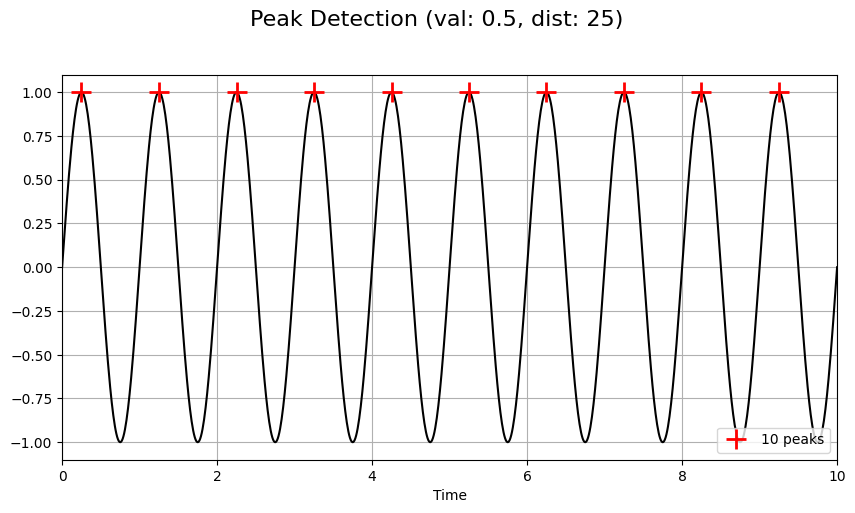

Peak Times: [0.25025025 1.25125125 2.25225225 3.25325325 4.25425425 5.24524525
 6.24624625 7.24724725 8.24824825 9.24924925]
Peak Values: [0.99999876 0.9999691  0.99989987 0.99979109 0.99964277 0.99955378
 0.99972187 0.99985043 0.99993943 0.99998887]


In [4]:
# Call find_peaks function
result = find_peaks(
    time,
    signal,
    peak_type="peak",
    min_val=0.5,
    min_dist=25,
    detrend=0,
    plot=True,
    show_grid=True,
    fig_size=(10, 5)
)

# Unpack the result based on the number of returned values
if len(result) == 2:
    peak_times, peak_values = result
    signal_detrended = None
elif len(result) == 3:
    peak_times, peak_values, signal_detrended = result

# Print the detected peaks' times and values
print("Peak Times:", peak_times)
print("Peak Values:", peak_values)

# Optionally, you can also print the detrended signal
if signal_detrended is not None:
    print("Detrended Signal:", signal_detrended)
